# Exploratory Data Analysis (EDA)

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## Merge The Sources

In [3]:
path1 = os.path.abspath('../data/saved_data/clean_citibike_trips.parquet')
path2 = os.path.abspath('../data/saved_data/clean_citibike_stations.parquet')

In [4]:
df1 = pd.read_parquet(path1)
df2 = pd.read_parquet(path2)

In [5]:
df1 = df1[2024 < df1['started_at'].dt.year]

## Remove Outliers

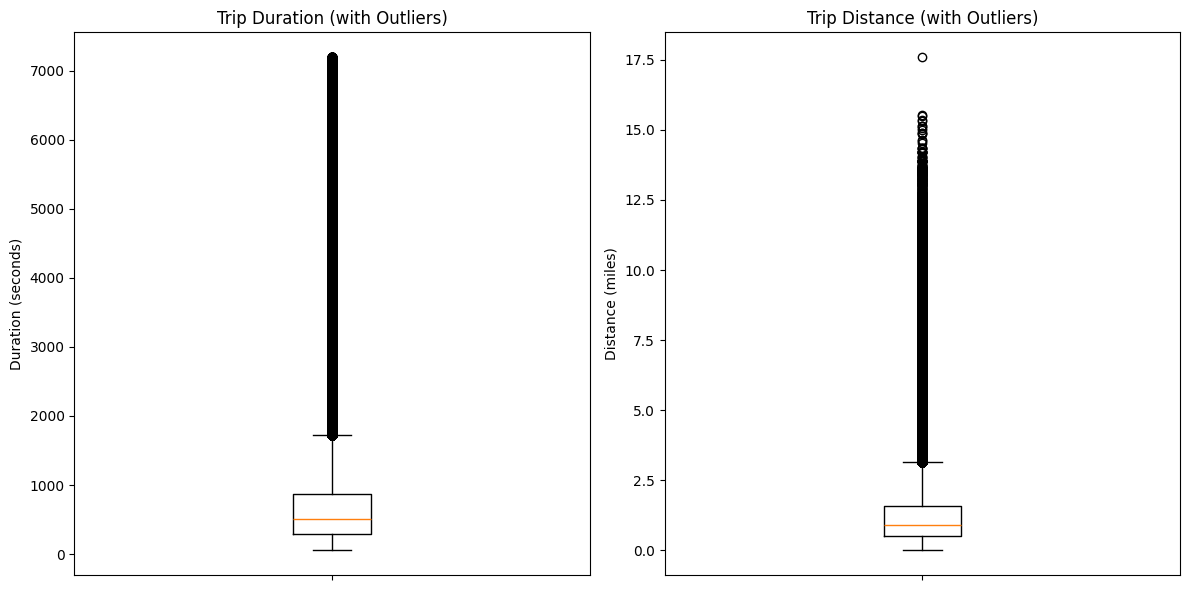

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].boxplot(
    data=df1,
    x='trip_duration',
)

axs[0].set_title('Trip Duration (with Outliers)')
axs[0].set_ylabel('Duration (seconds)')
axs[0].set_xticklabels([''])

axs[1].boxplot(
    data=df1,
    x='trip_distance',
)

axs[1].set_title('Trip Distance (with Outliers)')
axs[1].set_ylabel('Distance (miles)')
axs[1].set_xticklabels([''])

plt.tight_layout()
plt.show()

In [7]:
def remove_outliers(df, column):
    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)

    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    filter_query = (df[column] > lower_bound) & (df[column] < upper_bound)
    return df[filter_query]

df1 = remove_outliers(df1, 'trip_duration')
df1 = remove_outliers(df1, 'trip_distance')

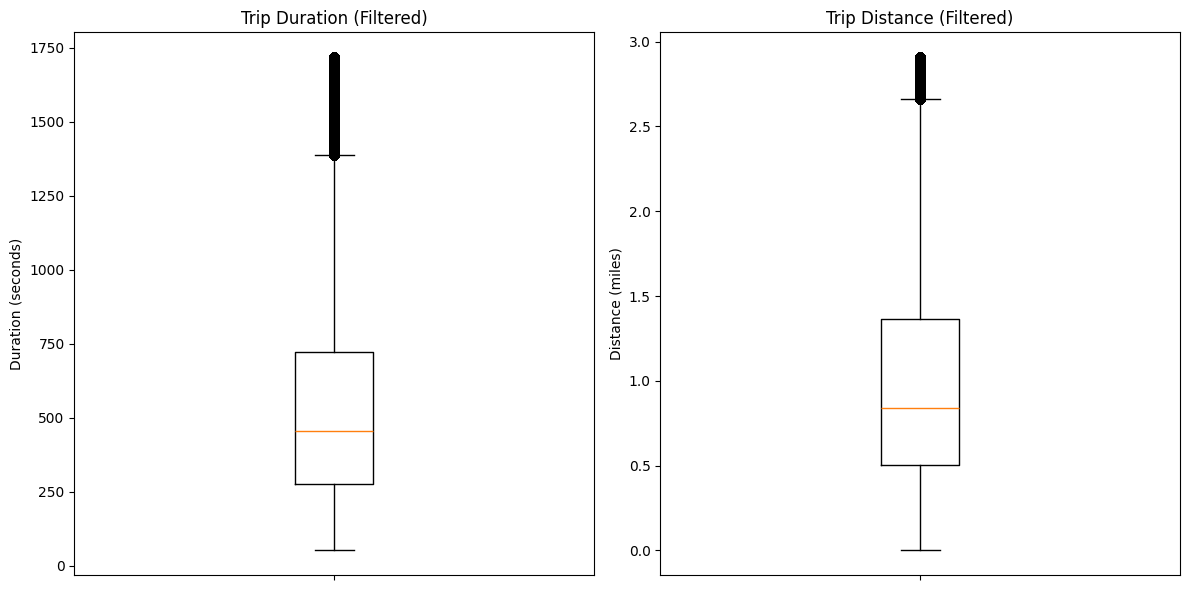

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].boxplot(
    data=df1,
    x='trip_duration',
)

axs[0].set_title('Trip Duration (Filtered)')
axs[0].set_ylabel('Duration (seconds)')
axs[0].set_xticklabels([''])

axs[1].boxplot(
    data=df1,
    x='trip_distance',
)

axs[1].set_title('Trip Distance (Filtered)')
axs[1].set_ylabel('Distance (miles)')
axs[1].set_xticklabels([''])

plt.tight_layout()
plt.show()

## Save Data Without Outliers

In [9]:
df1.to_parquet('../data/saved_data/without_outliers_citibike_trips.parquet')

In [10]:
first_merge = df1.merge(
    right=df2[['borough', 'postcode']].add_prefix('start_'),
    how='left',
    left_on='start_station_id',
    right_index=True
)

df3 = first_merge.merge(
    right=df2[['borough', 'postcode']].add_prefix('end_'),
    how='left',
    left_on='end_station_id',
    right_index=True
)

if df3.shape[0] == df1.shape[0]:
    print('Dataframes successfully merged!')

Dataframes successfully merged!


## 2. Analyze Trips

### 2a. Display statistics on the time and distance traveled by each borough.

- **Manhattan** and **Brooklyn** have the most frequent trips with the highest average trip time/distance
- Bike trips average around **10 minutes** and **1 mile**
- Dispersion of time and duration across the 5 boroughs is almost close (**Brooklyn** has higher trip duration based on the IQR)

In [11]:
df3.groupby(
    'start_borough'
)[
    [
        'trip_duration',
        'trip_distance'
    ]
].agg(
    ['mean', 'median', 'std', 'count']
)

trip_duration                         trip_distance              \
                       mean median    std     count          mean median  std   
start_borough                                                                   
Brooklyn             549.00 460.00 348.48   4864436          1.04   0.86 0.68   
Manhattan            540.81 463.00 334.65  11388903          0.99   0.85 0.63   
Queens               481.27 386.00 330.84   1220654          0.90   0.71 0.65   
The Bronx            489.72 402.00 334.84    514579          0.91   0.74 0.66   

                         
                  count  
start_borough            
Brooklyn        4864436  
Manhattan      11388903  
Queens          1220654  
The Bronx        514579

In [12]:
def calculate_iqr(data):
    q1 = np.quantile(data, 0.25)
    q2 = np.quantile(data, 0.75)
    return q2 - q1

df3.groupby(
    'start_borough'
)[
    [
        'trip_duration',
        'trip_distance'
    ]
].agg(
    ['median', calculate_iqr]
)

trip_duration               trip_distance              
                     median calculate_iqr        median calculate_iqr
start_borough                                                        
Brooklyn             460.00        473.00          0.86          0.94
Manhattan            463.00        434.00          0.85          0.84
Queens               386.00        412.00          0.71          0.81
The Bronx            402.00        428.00          0.74          0.90

### 2b. Create a histogram for the duration/time of trips by bike type.

- Both distributions are **right-skewed**
- Shaped like an **exponential** distribution
- Riders are more often riding electric bikes

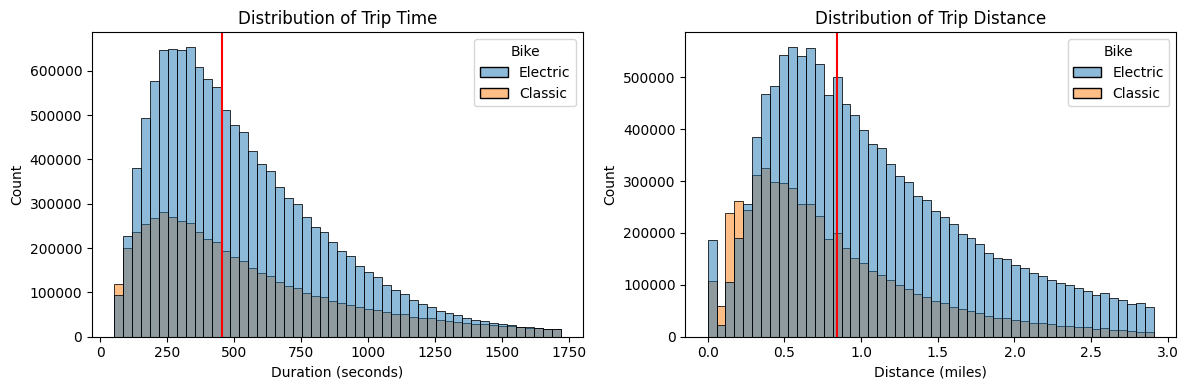

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

median_duration, median_distance = df3['trip_duration'].median(), df3['trip_distance'].median()

sns.histplot(
    data=df3,
    x='trip_duration',
    hue='rideable_type',
    bins=50,
    ax=axs[0],
)

axs[0].axvline(median_duration, color='red')
axs[0].set_title('Distribution of Trip Time')
axs[0].set_xlabel('Duration (seconds)')
axs[0].get_legend().set_title('Bike')

sns.histplot(
    data=df3,
    x='trip_distance',
    hue='rideable_type',
    bins=50,
    ax=axs[1]
)

axs[1].axvline(median_distance, color='red')
axs[1].set_title('Distribution of Trip Distance')
axs[1].set_xlabel('Distance (miles)')
axs[1].get_legend().set_title('Bike')

plt.tight_layout()
plt.show()

### 2c. Create a matrix for total riders by month and weekday

- **January** and **February** were the lowest performing months
- Bike riding picks up after **March**

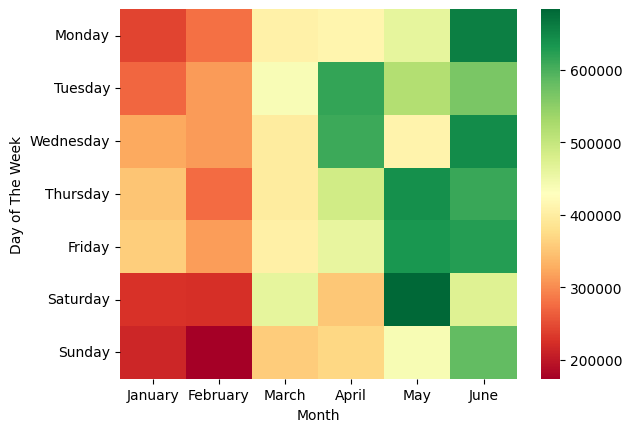

In [14]:
df3['day_name'] = df3['started_at'].dt.day_name()
df3['month'] = df3['started_at'].dt.month_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

matrix_1 = df3.pivot_table(
    index='day_name',
    columns='month',
    aggfunc='size',
    fill_value=0
    )[
        ['January', 'February', 'March', 'April', 'May', 'June']
    ]

matrix_1 = matrix_1.reindex(day_order)

sns.heatmap(
    matrix_1,
    cmap='RdYlGn'
)

plt.xlabel('Month')
plt.ylabel('Day of The Week')
plt.show()

### 2d. Create a matrix for total riders by hour and weekdays

- There are two peaks for the total number of riders on weekdays (Monday-Friday), **6-9am**, and **5-7pm**
- During rush hours, the bikes are being used to travel to work or home

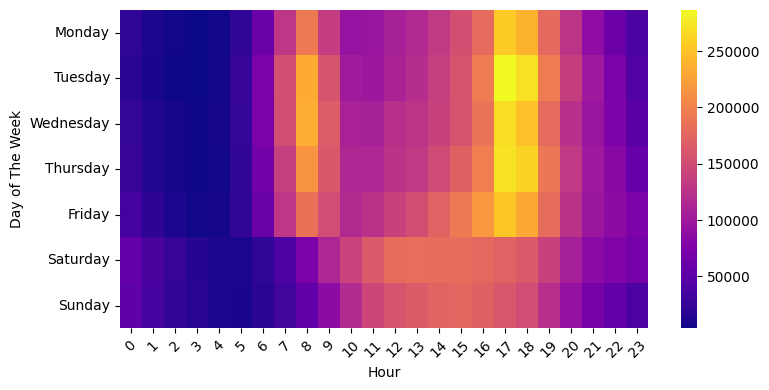

In [15]:
df3['start_hour'] = df3['started_at'].dt.hour 

matrix_2 = df3.pivot_table(index='day_name', columns='start_hour', aggfunc='size', fill_value=0)
matrix_2 = matrix_2.reindex(day_order)

plt.figure(figsize=(8, 4))

sns.heatmap(
    matrix_2,
    cmap='plasma'
)

plt.xlabel('Hour')
plt.ylabel('Day of The Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2e. Popular starting bike stations by borough

- The starting locations are at hot spots with **restaurants**, **stadiums**, **museums**, **parks**, **bridges**, **piers**, and more

In [16]:
df3.groupby(
    [
        'start_borough',
    ]
)['start_station_name'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough'
    }
    ).to_frame(name='Popular Stations')

Popular Stations
Borough                                                     
Brooklyn  N 7 St & Driggs Ave                          40639
          N 6 St & Bedford Ave                         36992
          Metropolitan Ave & Bedford Ave               35236
          Hanson Pl & Ashland Pl                       35006
          S 2 St & Kent Ave                            34639
Manhattan W 21 St & 6 Ave                              71411
          Pier 61 at Chelsea Piers                     62509
          Lafayette St & E 8 St                        59767
          W 31 St & 7 Ave                              57492
          Broadway & E 14 St                           54516
Queens    Queens Plaza North & Crescent St             20076
          Vernon Blvd & 50 Ave                         19916
          Jackson Ave & 49 Ave                         18539
          46 Ave & 5 St                                18205
          31 St & Broadway                             17645
The Bronx E 161 St & River Ave                          8377
          Melrose Ave & E 150 St                        7890
          Grand Concourse & E 161 St                    5330
          Plaza Dr & W 170 St                           5254
          Lincoln Ave & E 138 St                        4909

### 2f. Popular end stations by borough

- Similar to the popular start stations, most riders start and end trips at these hot spots

In [17]:
df3.groupby(
    ['start_borough']
)['end_station_name'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough'
    }
).to_frame('Popular End Stations')

Popular End Stations
Borough                                                       
Brooklyn  N 7 St & Driggs Ave                            37542
          Hanson Pl & Ashland Pl                         34263
          N 6 St & Bedford Ave                           33232
          Metropolitan Ave & Bedford Ave                 30073
          S 2 St & Kent Ave                              29491
Manhattan W 21 St & 6 Ave                                70965
          Pier 61 at Chelsea Piers                       61193
          Lafayette St & E 8 St                          57931
          W 31 St & 7 Ave                                57810
          9 Ave & W 33 St                                55042
Queens    31 St & Broadway                               17078
          31 St & Newtown Ave                            15061
          46 Ave & 5 St                                  14742
          Steinway St & Broadway                         14376
          31 St & Ditmars Blvd                           14021
The Bronx Melrose Ave & E 150 St                          7686
          E 161 St & River Ave                            7116
          Plaza Dr & W 170 St                             4961
          Morris Ave & E 163 St                           4244
          Grand Concourse & E 161 St                      4240

### 2g. Top 10 zip codes with the most Citi Bike stations near the area

- **Long Island City** has multiple Citi bike stations, this area allows riders to access the 5 boroughs easily

In [18]:
df3.groupby(
    'start_postcode'
)['start_station_id'].agg(
    'nunique'
).sort_values(ascending=False).rename_axis(
    index={
        'start_postcode': 'Zip Code'
    }
).head(10).to_frame(
    'Number of Stations'
)

,Number of Stations
Zip Code,
11101,73
11233,52
11377,48
11368,44
11385,39
11373,39
11215,38
11211,37
11231,37


## 3. Analyze Users

### 3a. Create a box plot with the relationship of trip duration by boroughs and users

- **Casual** users on average spend more time on bikes than users with a membership 

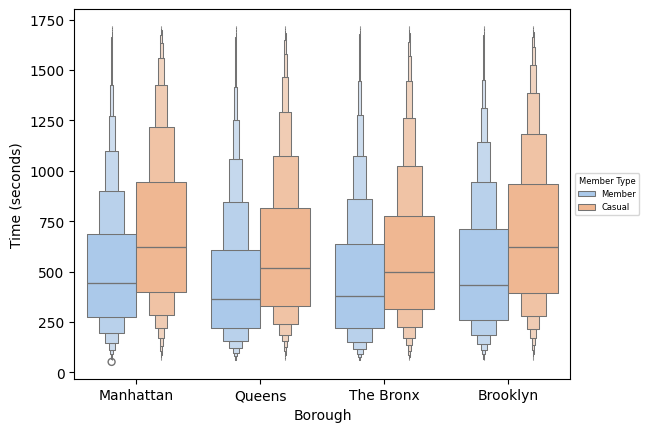

In [19]:
sns.boxenplot(
    data=df3,
    x='start_borough',
    y='trip_duration',
    hue='member_casual',
    palette='pastel'
    )

plt_legend = plt.legend(fontsize=6, loc='center left', bbox_to_anchor=(1, 0.5))
plt_legend.set_title('Member Type', prop={'size': 6})
plt.xlabel('Borough')
plt.ylabel('Time (seconds)')
plt.show()

### 3b. What are the most popular start and end stations by boroughs and users?

- **Casual** users typically return the bike at the same station
- **Member** users are most likely local residents

In [20]:
df3.groupby(
    ['start_borough', 'member_casual']
)[['start_station_name', 'end_station_name']].apply(
    lambda group:
    group.value_counts().head(5)
).rename_axis(
    index={
        'member_casual': 'User',
        'start_borough': 'Borough',
        'start_station_name': 'Starting Station',
        'end_station_name': 'Ending Station'
    }
).to_frame('Count')

Count
Borough   User   Starting Station                  Ending Station                          
Brooklyn  Casual West Drive & Prospect Park West   West Drive & Prospect Park West      465
                 Brooklyn Bridge Park - Pier 2     Brooklyn Bridge Park - Pier 2        361
                 West Drive & Prospect Park West   Parkside Ave & Ocean Ave             333
                 Main St & Plymouth St             Main St & Plymouth St                324
                 Parkside Ave & Ocean Ave          Parkside Ave & Ocean Ave             316
          Member Franklin St & Dupont St           Jackson Ave & 49 Ave                2857
                 N 6 St & Bedford Ave              S 4 St & Wythe Ave                  2245
                                                   S 2 St & Kent Ave                   2106
                 Richardson St & N Henry St        Graham Ave & Conselyea St           2024
                 S 4 St & Wythe Ave                N 6 St & Bedford Ave                1991
Manhattan Casual Central Park S & 6 Ave            Central Park S & 6 Ave              1824
                 7 Ave & Central Park South        7 Ave & Central Park South          1364
                 Roosevelt Island Tramway          Roosevelt Island Tramway            1355
                 Central Park S & Grand Army Plaza Central Park S & Grand Army Plaza   1089
                 Centre St & Chambers St           Centre St & Chambers St              916
          Member Norfolk St & Broome St            Henry St & Grand St                 3032
                 Henry St & Grand St               Norfolk St & Broome St              2777
                 W 21 St & 6 Ave                   9 Ave & W 22 St                     2670
                 North Moore St & Greenwich St     Vesey St & Greenwich St             2663
                 E 77 St & 1 Ave                   2 Ave & E 72 St                     2572
Queens    Casual Jackson Ave & 49 Ave              Franklin St & Dupont St              485
                                                   Ash St & Manhattan Ave               277
                 55 Ave & Center Blvd              Vernon Blvd & 50 Ave                 252
                 Jackson Ave & 49 Ave              McGuinness Blvd & Eagle St           205
                 44 Dr & Jackson Ave               46 Ave & 5 St                        184
          Member 55 Ave & Center Blvd              Vernon Blvd & 50 Ave                2832
                 Vernon Blvd & 50 Ave              55 Ave & Center Blvd                2615
                 Jackson Ave & 49 Ave              Franklin St & Dupont St             2559
                 46 Ave & 5 St                     45 Ave & 21 St                      1793
                                                   Vernon Blvd & 50 Ave                1742
The Bronx Casual E 161 St & River Ave              E 161 St & River Ave                 155
                 Crescent Ave & Belmont Ave        E 188 St & Creston Ave               120
                 Ogden Ave & W 165 St              E 161 St & River Ave                  99
                 Brook Ave & E 138 St              Brook Ave & E 138 St                  94
                 Broadway & Van Cortlandt Park S   Broadway & Van Cortlandt Park S       85
          Member E 161 St & River Ave              E 161 St & River Ave                 486
                 Paul Ave & W 205 St               Jerome Ave & Bedford Park Blvd E     431
                 Goulden Ave & W 205 St            Jerome Ave & Bedford Park Blvd E     387
                 Jerome Ave & Bedford Park Blvd E  Paul Ave & W 205 St                  360
                 Gerard Ave & E 146 St             Gerard Ave & E 146 St                346

### 3c. Number of Citi Bike users by borough and area code

- Hot area codes for users by each borough
    - **The Bronx**: Yankee Stadium
    - **Manhattan**: 59th Street
    - **Queens**: Long Island City
    - **Brooklyn**: Williamsburg Bridge

In [21]:
df3.groupby(
    ['start_borough', 'member_casual']
)['start_postcode'].apply(
    lambda group:
    group.value_counts().head()
).rename_axis(
    index={
        'start_borough': 'Borough',
        'member_casual': 'User'
    }
).to_frame('Top Area Code')

Top Area Code
Borough   User                       
Brooklyn  Casual 11211          76692
                 11249          65416
                 11222          53785
                 11201          53315
                 11215          50089
          Member 11211         405151
                 11222         342241
                 11249         310911
                 11215         309170
                 11201         267594
Manhattan Casual 10014          99510
                 10019          97927
                 10003          93819
                 10002          87581
                 10011          82701
          Member 10003         673557
                 10009         632866
                 10019         628611
                 10011         607203
                 10002         588433
Queens    Casual 11101          43620
                 11385          17384
                 11377          14982
                 11372          12078
                 11373          11616
          Member 11101         283142
                 11377          86288
                 11106          81010
                 11385          67602
                 11103          66899
The Bronx Casual 10451          12911
                 10456          11900
                 10458           8480
                 10468           8292
                 10457           7734
          Member 10456          64870
                 10451          61463
                 10457          36244
                 10452          34532
                 10454          33094